# Week 6 Assignment - The Best Classifier

In this assignment, a historical dataset from loan applications wil be analysed with the following classification algorithm :
1. k-Nearest Neighbours
2. Decision Tree
3. Support Vector Machine
4. Logistic Regression

The results of the analysis will be reported as the accuracy of each classifier, using the following metrics when applicable:
1. Jaccard index
2. F1-score 
3. Log Loss

### First let's load required libraries for this assignment

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import scipy.optimize as opt

from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline

### Then we download the required the historical dataset from loan applications

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-11-28 07:14:07--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.08s   

2020-11-28 07:14:08 (267 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load the data into a dataframe and display the first 5 rows of the dataframe

In [3]:
df = pd.read_csv('loan_train.csv')
print('size = ', df.size)
df.head()

size =  3460


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


Let's explore the given data set with standard statistics

In [4]:
df.describe(include='all')

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
count,346.000000,346.000000,346,346.000000,346.000000,346,346,346.000000,346,346
unique,NaN,NaN,2,NaN,NaN,7,23,NaN,4,2
top,NaN,NaN,PAIDOFF,NaN,NaN,9/11/2016,10/10/2016,NaN,High School or Below,male
freq,NaN,NaN,260,NaN,NaN,166,90,NaN,151,294
mean,202.167630,202.167630,NaN,943.641618,22.653179,NaN,NaN,30.939306,NaN,NaN
std,115.459715,115.459715,NaN,109.425530,7.991006,NaN,NaN,6.039418,NaN,NaN
min,0.000000,0.000000,NaN,300.000000,7.000000,NaN,NaN,18.000000,NaN,NaN
25%,107.250000,107.250000,NaN,900.000000,15.000000,NaN,NaN,27.000000,NaN,NaN
50%,204.500000,204.500000,NaN,1000.000000,30.000000,NaN,NaN,30.000000,NaN,NaN
75%,298.750000,298.750000,NaN,1000.000000,30.000000,NaN,NaN,35.000000,NaN,NaN


From above table we have some idea on how the data set looks like. 

### Data pre-processing and selection

Let's first select the only required columns to be analysed, rearrange the columns and put them into new data frame **feature_df**

In [5]:
feature_df = df[[ 'age','education', 'Gender', 'Principal', 'terms','loan_status']]
feature_df.head()

,age,education,Gender,Principal,terms,loan_status
0,45,High School or Below,male,1000,30,PAIDOFF
1,33,Bechalor,female,1000,30,PAIDOFF
2,27,college,male,1000,15,PAIDOFF
3,28,college,female,1000,30,PAIDOFF
4,29,college,male,1000,30,PAIDOFF


Using the above table, declare the following variables:
<ul>
    <li> <b> X </b> as the <b> Feature Matrix </li>
    <li> <b> y </b> as the <b> response vector (target) </b> </li>
</ul>

In [6]:
X = feature_df[['age', 'education', 'Gender', 'Principal', 'terms']].values  
X[0:5]

array([[45, 'High School or Below', 'male', 1000, 30],
       [33, 'Bechalor', 'female', 1000, 30],
       [27, 'college', 'male', 1000, 15],
       [28, 'college', 'female', 1000, 30],
       [29, 'college', 'male', 1000, 30]], dtype=object)

In [7]:
y = feature_df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

As you may figure out, some features in this dataset are categorical such as Gender, education or loan_status. In order to ease the analysis, these features have to be converted to numerical values. Here, pandas.get_dummies() convert categorical variable into dummy/indicator variables.

In [8]:
from sklearn import preprocessing

le_ed = preprocessing.LabelEncoder()
le_ed.fit(['High School or Below', 'Bechalor', 'college', 'Master or Above'])
X[:,1] = le_ed.transform(X[:,1]) 


le_gdr = preprocessing.LabelEncoder()
le_gdr.fit(['male', 'female'])
X[:,2] = le_gdr.transform(X[:,2]) 

X[0:5]

array([[45, 1, 1, 1000, 30],
       [33, 0, 0, 1000, 30],
       [27, 3, 1, 1000, 15],
       [28, 3, 0, 1000, 30],
       [29, 3, 1, 1000, 30]], dtype=object)

Data is preprocessed and ready to be analysed.

## 1. k-Nearest Neighbors Analysis

Let's define feature set, **X**:

In [10]:
X[0:5]

array([[45, 1, 1, 1000, 30],
       [33, 0, 0, 1000, 30],
       [27, 3, 1, 1000, 15],
       [28, 3, 0, 1000, 30],
       [29, 3, 1, 1000, 30]], dtype=object)

and target variable **y**:

In [23]:
y = feature_df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

Normalize the data

In [12]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[ 2.33152555, -0.64691859,  0.42056004,  0.51578458,  0.92071769],
       [ 0.34170148, -1.5212695 , -2.37778177,  0.51578458,  0.92071769],
       [-0.65321055,  1.10178323,  0.42056004,  0.51578458, -0.95911111],
       [-0.48739188,  1.10178323, -2.37778177,  0.51578458,  0.92071769],
       [-0.3215732 ,  1.10178323,  0.42056004,  0.51578458,  0.92071769]])

Split train and test set

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 5) (276,)
Test set: (70, 5) (70,)


Import the library 

In [25]:
from sklearn.neighbors import KNeighborsClassifier

We start the algorithm with k=4:

In [26]:
k = 4
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(n_neighbors=4)

We can use the mode to predict the test set:

In [27]:
yhat = neigh.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF'],
      dtype=object)

### Model Evaluation

We then evaluate the accuracy of the model with the following steps

In [28]:
from sklearn import metrics

print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.7355072463768116
Test set Accuracy:  0.6571428571428571


What about different number of k? This time we calculate the accuracy of k-Nearest Neighbors for different k's

In [29]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.65714286, 0.55714286, 0.68571429, 0.65714286, 0.77142857,
       0.71428571, 0.74285714, 0.72857143, 0.74285714])

Plot model accuracy for different number of neighbors

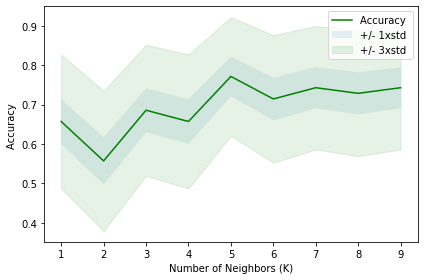

In [30]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [31]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7714285714285715 with k= 5


## 2. Decision Tree Analysis

For the sake of comparison, we will use the same train/test split set as described above. 

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 5) (276,)
Test set: (70, 5) (70,)


Import the library and start building the decision tree model

In [22]:
loandisc = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loandisc # it shows the default parameters

DecisionTreeClassifier(criterion='entropy', max_depth=4)

We fit the training feature matrix X_trainset and training response vector y_trainset

In [33]:
loandisc.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

We can make some predictions on the testing dataset

In [34]:
predloan = loandisc.predict(X_test)

You can print out predloan and y_test if you want to visually compare the prediction to the actual values.

In [35]:
print(predloan[0:5])
print(y_test[0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


### Model Evaluation

Import library from sklearn to check the accuracy of the model.

In [37]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predloan))

DecisionTrees's Accuracy:  0.7857142857142857


### Visualization

Lets visualize the tree

In [38]:
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: | 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
                                                                                                           /failed

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - cffi -> python[version='2.7.*|3.5.*|3.6.*|3.6.9|3.6.9|3.6.9|3.6.9|>=3.6,<3.7.0a0|>=3.9,<3.10.0a0|>=3.8,<3.9.0a0|>=3.7,<3.8.0a0|>=2.7,<2.8.0a0|>=3.5,<3.6.0a0|3.4.*',build='1_73_pypy|2_73_pypy|3_73_pypy|0_73_pypy']
  - rsa -> python[version='2.7.*|3.4.*|3.5.*|3.6.*']

Your python: python=3.7

If python is on the lef

In [39]:
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

ModuleNotFoundError: No module named 'pydotplus'

In [ ]:
dot_data = StringIO()
filename = "loandectree.png"
featureNames = feature_df.columns[0:5]
targetNames = feature_df["loan_status"].unique().tolist()
out=tree.export_graphviz(drugTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')